In [96]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneGroupOut
import matplotlib.pyplot as plt

In [97]:
np.random.seed(42)

## Load data

In [98]:
dataset_folders = [
    'datasets/twitter-roberta-base-sentiment',
    'datasets/twitter-xlm-roberta-base-sentiment',
    'datasets/wine_1',
    'datasets/spam_detection_1',
    'datasets/spam_detection_2',
    'datasets/spam_detection_3',
    'datasets/spam_detection_4',
    'datasets/spam_detection_5',
    'datasets/spam_detection_6',
]

features = [
    'threshold',
    'FLOPS',
    'params_reduction_pct',
    'non_zero_params',
    'num_classes',
    'accuracy',
]

df = pd.DataFrame()
for idx, folder in enumerate(dataset_folders):
    df_full = pd.read_csv(f'{folder}/pruning_threshold_results.csv')
    df_temp = df_full[['threshold', 'flops', 'params_reduction_pct', 'non_zero_params', 'overall_accuracy']]
    df_temp = df_temp.rename(columns={'overall_accuracy': 'accuracy', 'flops': 'FLOPS'})
    df_temp['threshold'] = pd.to_numeric(df_temp['threshold'], errors='coerce')
    df_temp['model_id'] = idx

    # Calculate the number of classes based on the count of *_accuracy columns
    num_classes = len([col for col in df_full.columns if col.endswith('_accuracy')]) - 1

    df_temp['num_classes'] = num_classes
    df_temp = df_temp.dropna()
    df = pd.concat([df, df_temp], ignore_index=True)

df = df[features + ['model_id']]

df.head()

,threshold,FLOPS,params_reduction_pct,non_zero_params,num_classes,accuracy,model_id
0,0.0,1.117356e+10,0.000000,124647171,3,0.717035,0
1,0.1,1.099988e+10,1.554351,122709716,3,0.717883,0
2,0.2,1.082690e+10,3.102511,120779979,3,0.718166,0
3,0.3,1.065479e+10,4.642797,118860056,3,0.718449,0
4,0.4,1.048449e+10,6.166902,116960302,3,0.717883,0


## Prepare the input data and labels

In [99]:
X_all = []
y_all = []
model_ids = []

for model_id, data in df.groupby('model_id'):
    data = data.sort_values('threshold')
    
    for i in range(1, len(data)):
        prev_row = data.iloc[i-1]
        curr_row = data.iloc[i]
        
        X = [
            curr_row['threshold'],
            curr_row['FLOPS'],
            curr_row['params_reduction_pct'],
            curr_row['non_zero_params'],
            curr_row['num_classes'],
            prev_row['accuracy']
        ]
        
        # Target is now the CHANGE in accuracy
        y = curr_row['accuracy'] - prev_row['accuracy']
        
        X_all.append(X)
        y_all.append(y)
        model_ids.append(model_id)

X = np.array(X_all)
y = np.array(y_all).reshape(-1, 1)
model_ids = np.array(model_ids)

## Scale the data

In [100]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

## Predict an entire sequence

In [101]:
def predict_sequential_thresholds_delta(model, initial_data, thresholds, scaler_X, scaler_y):
    predictions = []
    current_accuracy = initial_data['initial_accuracy']
    
    for threshold in thresholds:
        features = [
            threshold,
            initial_data['FLOPS'],
            initial_data['params_reduction_pct'],
            initial_data['non_zero_params'],
            initial_data['num_classes'],
            current_accuracy
        ]
        
        # Scale and predict the CHANGE in accuracy
        features_scaled = scaler_X.transform([features])
        features_reshaped = features_scaled.reshape(1, 1, features_scaled.shape[1])
        delta_scaled = model.predict(features_reshaped, verbose=0)
        delta = scaler_y.inverse_transform(delta_scaled)[0][0]
        
        # Apply the change to get new accuracy
        new_accuracy = current_accuracy + delta
        predictions.append(new_accuracy)
        current_accuracy = new_accuracy
    
    return predictions

# Leave one group out cross-validation

In [102]:
logo = LeaveOneGroupOut()
all_model_errors = []
all_thresholds = np.arange(0.1, 3.1, 0.1)  # Thresholds from 0.1 to 3.0 in steps of 0.1

# Store actual vs predicted values for plotting
all_actual_curves = []
all_predicted_curves = []
all_model_ids_test = []

for train_val_idx, test_idx in logo.split(X_scaled, y_scaled, groups=model_ids):
    X_train_val = X_scaled[train_val_idx]
    y_train_val = y_scaled[train_val_idx]
    model_ids_train_val = model_ids[train_val_idx]
    
    # From the training+validation set, select one model for validation
    unique_train_val_models = np.unique(model_ids_train_val)
    val_model_id = np.random.choice(unique_train_val_models, size=1)[0]
    
    # Create masks for train and validation
    val_mask = model_ids_train_val == val_model_id
    train_mask = ~val_mask
    
    # Final split
    X_train = X_train_val[train_mask]
    y_train = y_train_val[train_mask]
    X_val = X_train_val[val_mask]
    y_val = y_train_val[val_mask]
    X_test = X_scaled[test_idx]
    y_test = y_scaled[test_idx]
    
    # Reshape data for LSTM
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    # Define and train model
    input_dim = X_train.shape[1]
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.1),
        LSTM(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=150,
        batch_size=32,
        validation_data=(X_val_reshaped, y_val),
        verbose=1
    )
    
    # Get the test model ID
    test_model_id = model_ids[test_idx][0]
    all_model_ids_test.append(test_model_id)
    
    # Get initial data for this test model from the original dataframe
    test_model_data = df[df['model_id'] == test_model_id].sort_values('threshold')
    initial_data = {
        'FLOPS': test_model_data.iloc[0]['FLOPS'],
        'params_reduction_pct': test_model_data.iloc[0]['params_reduction_pct'],
        'non_zero_params': test_model_data.iloc[0]['non_zero_params'],
        'initial_accuracy': test_model_data.iloc[0]['accuracy'],
        'num_classes': test_model_data.iloc[0]['num_classes'],
    }
    
    # Make sequential predictions for all thresholds
    predicted_accuracies = predict_sequential_thresholds_delta(
        model, initial_data, all_thresholds, scaler_X, scaler_y
    )
    
    # Get actual accuracies for comparison (from original dataframe)
    actual_accuracies = []
    for threshold in all_thresholds:
        # Find closest threshold in the original data
        closest_row = test_model_data.iloc[(test_model_data['threshold'] - threshold).abs().argsort()[:1]]
        actual_accuracies.append(closest_row['accuracy'].values[0])
    
    # Calculate mean absolute error for this model
    model_error = np.mean(np.abs(np.array(actual_accuracies) - np.array(predicted_accuracies)))
    all_model_errors.append(model_error)
    
    # Store actual and predicted curves for plotting
    all_actual_curves.append(actual_accuracies)
    all_predicted_curves.append(predicted_accuracies)
    
    print(f"Model {test_model_id} - Mean Absolute Error: {model_error:.4f}")

# Calculate overall error
overall_mae = np.mean(all_model_errors)
print(f"\nOverall Mean Absolute Error across all models: {overall_mae:.4f}")

Epoch 1/150


/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4997 - val_loss: 0.2367
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5885 - val_loss: 0.1956
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4674 - val_loss: 0.1531
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3504 - val_loss: 0.1337
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3642 - val_loss: 0.1446
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4525 - val_loss: 0.1312
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3925 - val_loss: 0.1324
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3284 - val_loss: 0.1341
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3676 - val_loss: 0.1338
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4078 - val_loss: 0.1319
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4142 - val_loss: 0.1300
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3844 - val_loss: 0.1291
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4507 - val_loss: 0.2431
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4174 - val_loss: 0.1561
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4230 - val_loss: 0.0407
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3515 - val_loss: 0.0481
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4067 - val_loss: 0.0234
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4433 - val_loss: 0.0293
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3891 - val_loss: 0.0244
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4416 - val_loss: 0.0198
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4007 - val_loss: 0.0179
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3333 - val_loss: 0.0195
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3854 - val_loss: 0.0163
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3368 - val_loss: 0.0164
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4896 - val_loss: 0.8817
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4274 - val_loss: 0.8610
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3778 - val_loss: 0.8416
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3164 - val_loss: 0.8511
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3151 - val_loss: 0.8489
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3120 - val_loss: 0.8402
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3613 - val_loss: 0.8408
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3495 - val_loss: 0.8432
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3896 - val_loss: 0.8408
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3286 - val_loss: 0.8399
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3631 - val_loss: 0.8391
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2974 - val_loss: 0.8387
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6207 - val_loss: 0.2176
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4823 - val_loss: 0.1627
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5413 - val_loss: 0.1304
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4427 - val_loss: 0.1455
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5561 - val_loss: 0.1337
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4812 - val_loss: 0.1355
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4958 - val_loss: 0.1365
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3680 - val_loss: 0.1351
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4928 - val_loss: 0.1315
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4219 - val_loss: 0.1293
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4265 - val_loss: 0.1285
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4084 - val_loss: 0.1289
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.6104 - val_loss: 0.2722
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5623 - val_loss: 0.2390
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5972 - val_loss: 0.2019
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4916 - val_loss: 0.1604
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4130 - val_loss: 0.1452
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4981 - val_loss: 0.1469
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4493 - val_loss: 0.1529
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5108 - val_loss: 0.1559
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3881 - val_loss: 0.1545
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4344 - val_loss: 0.1542
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4062 - val_loss: 0.1544
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4435 - val_loss: 0.1570
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.3698 - val_loss: 0.9073
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3247 - val_loss: 0.8793
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2799 - val_loss: 0.8474
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2287 - val_loss: 0.8470
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1936 - val_loss: 0.8495
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2242 - val_loss: 0.8516
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2036 - val_loss: 0.8557
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2094 - val_loss: 0.8570
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2550 - val_loss: 0.8532
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2414 - val_loss: 0.8528
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2093 - val_loss: 0.8538
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2075 - val_loss: 0.8537
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.5950 - val_loss: 0.2713
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6027 - val_loss: 0.2152
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4973 - val_loss: 0.1423
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3876 - val_loss: 0.0634
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5102 - val_loss: 0.0457
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4822 - val_loss: 0.0553
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3634 - val_loss: 0.0748
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4488 - val_loss: 0.0711
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4224 - val_loss: 0.0632
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4667 - val_loss: 0.0655
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4731 - val_loss: 0.0624
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5167 - val_loss: 0.0640
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.5266 - val_loss: 0.2546
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5636 - val_loss: 0.1752
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4537 - val_loss: 0.0677
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4025 - val_loss: 0.0496
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4694 - val_loss: 0.0326
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4655 - val_loss: 0.0322
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3762 - val_loss: 0.0289
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4167 - val_loss: 0.0217
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3728 - val_loss: 0.0321
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5144 - val_loss: 0.0234
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4655 - val_loss: 0.0223
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3843 - val_loss: 0.0212
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.5063 - val_loss: 0.2701
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3862 - val_loss: 0.2112
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4281 - val_loss: 0.1318
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2990 - val_loss: 0.0467
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4327 - val_loss: 0.0552
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3337 - val_loss: 0.0467
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3832 - val_loss: 0.0543
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3390 - val_loss: 0.0436
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3339 - val_loss: 0.0398
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3329 - val_loss: 0.0397
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3581 - val_loss: 0.0384
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3829 - val_loss: 0.0331
Epoch 13/150

## Plot the results

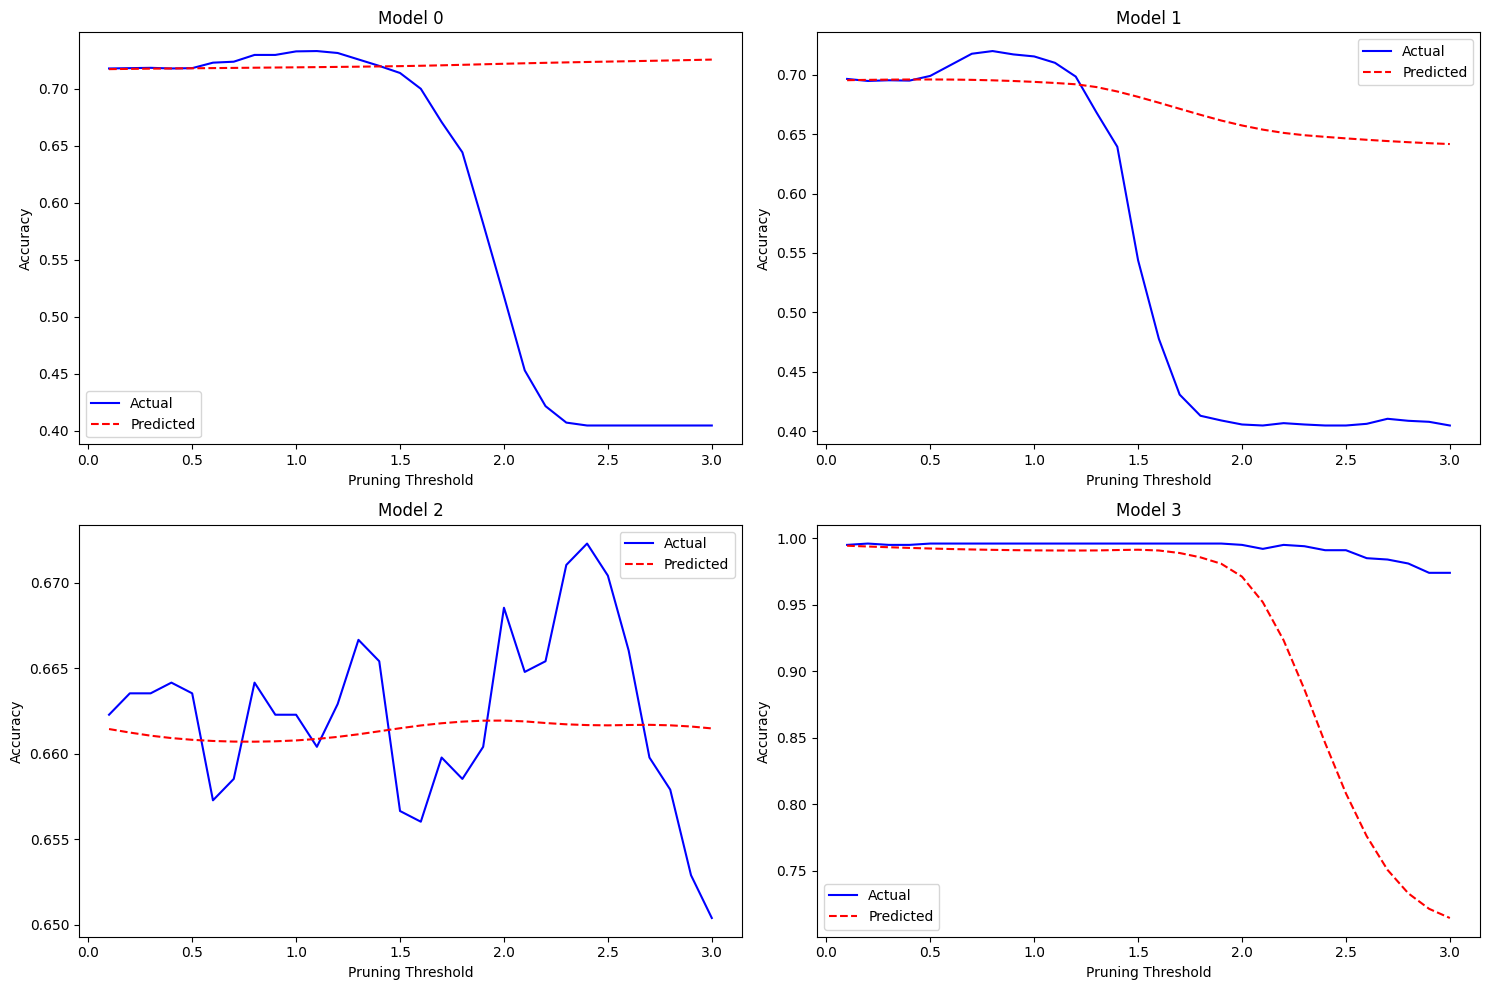

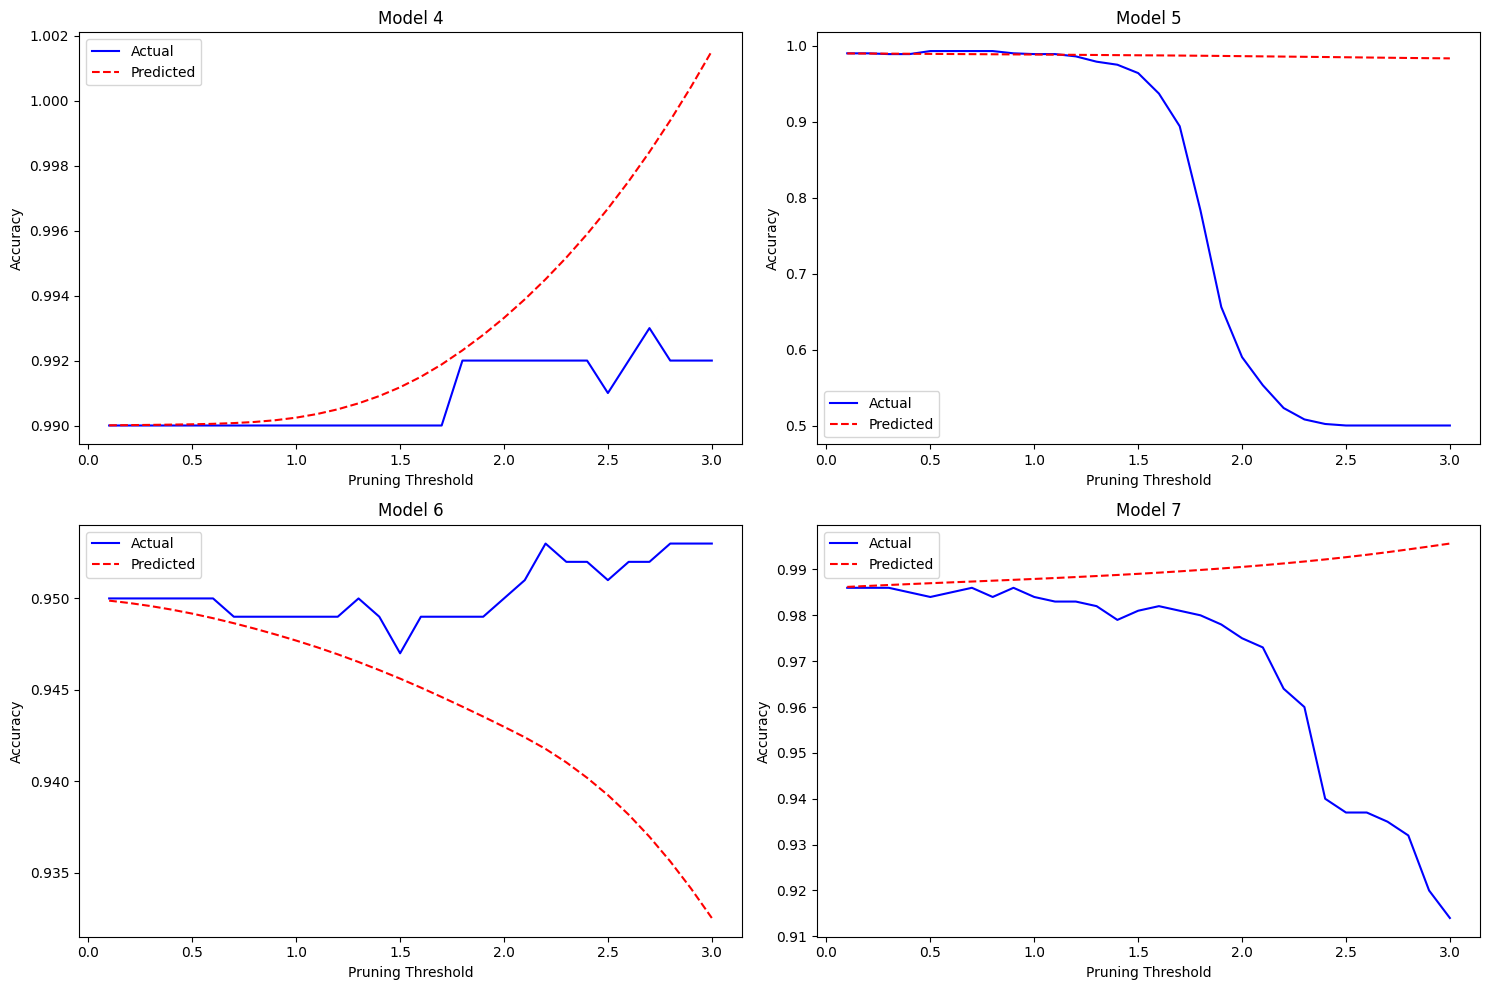

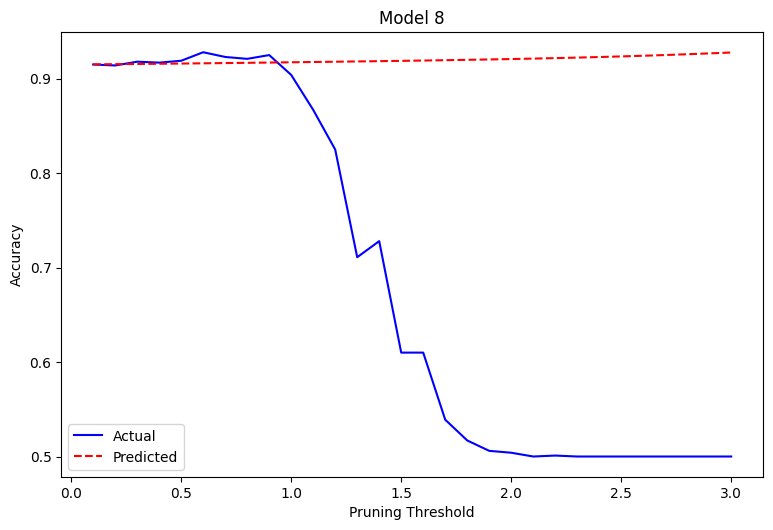

In [103]:
plt.figure(figsize=(15, 10))
for i in range(len(all_model_ids_test)):
    plt.subplot(2, 2, i % 4 + 1)
    plt.plot(all_thresholds, all_actual_curves[i], 'b-', label='Actual')
    plt.plot(all_thresholds, all_predicted_curves[i], 'r--', label='Predicted')
    plt.title(f'Model {all_model_ids_test[i]}')
    plt.xlabel('Pruning Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    
    if (i + 1) % 4 == 0 or i == len(all_model_ids_test) - 1:
        plt.tight_layout()
        plt.show()
        if i < len(all_model_ids_test) - 1:
            plt.figure(figsize=(15, 10))

## Cliff detector

In [104]:
# Extract critical thresholds from training data
critical_features = []
critical_thresholds = []

for model_id, data in df.groupby('model_id'):
    data = data.sort_values('threshold')
    accuracies = data['accuracy'].values
    thresholds = data['threshold'].values
    
    # Calculate rate of change in accuracy
    accuracy_diff = np.diff(accuracies)
    
    # Find the point of maximum accuracy drop
    if len(accuracy_diff) > 0:
        max_drop_idx = np.argmin(accuracy_diff)
        critical_threshold = thresholds[max_drop_idx + 1]
        
        # Feature vector for this model (use whatever features you have)
        model_features = [
            data.iloc[0]['FLOPS'],
            data.iloc[0]['params_reduction_pct'],
            data.iloc[0]['non_zero_params'],
            data.iloc[0]['accuracy']  # Starting accuracy
        ]
        
        critical_features.append(model_features)
        critical_thresholds.append(critical_threshold)

# Train a model to predict the critical threshold
from sklearn.ensemble import RandomForestRegressor
cliff_detector = RandomForestRegressor(n_estimators=100)
cliff_detector.fit(critical_features, critical_thresholds)

RandomForestRegressor()

In [105]:
def hybrid_predict(lstm_model, cliff_detector, initial_data, thresholds, scaler_X, scaler_y):
    # Predict the critical threshold where accuracy will drop
    model_features = [
        initial_data['FLOPS'],
        initial_data['params_reduction_pct'],
        initial_data['non_zero_params'],
        initial_data['initial_accuracy']
    ]
    critical_threshold = cliff_detector.predict([model_features])[0]
    
    # Make initial LSTM predictions
    lstm_predictions = predict_sequential_thresholds_delta(lstm_model, initial_data, thresholds, scaler_X, scaler_y)
    
    # Apply the parametric "plateau-then-cliff" model
    hybrid_predictions = []
    for i, threshold in enumerate(thresholds):
        if threshold < critical_threshold - 0.2:
            # Before cliff: maintain a plateau close to initial accuracy
            hybrid_predictions.append(initial_data['initial_accuracy'] * 0.98)
        elif threshold > critical_threshold + 0.2:
            # After cliff: low accuracy
            min_accuracy = 0.4  # Set based on your data
            hybrid_predictions.append(min_accuracy)
        else:
            # During transition: linear interpolation
            progress = (threshold - (critical_threshold - 0.2)) / 0.4
            start_acc = initial_data['initial_accuracy'] * 0.98
            end_acc = 0.4
            hybrid_predictions.append(start_acc + progress * (end_acc - start_acc))
    
    # Blend the two predictions (with emphasis on parametric model)
    final_predictions = []
    for i in range(len(thresholds)):
        # Weight more toward parametric model
        blended = 0.2 * lstm_predictions[i] + 0.8 * hybrid_predictions[i]
        final_predictions.append(blended)
    
    return final_predictions

In [107]:
logo = LeaveOneGroupOut()
all_model_errors = []
all_thresholds = np.arange(0.1, 3.1, 0.1)  # Thresholds from 0.1 to 3.0 in steps of 0.1

# Store actual vs predicted values for plotting
all_actual_curves = []
all_predicted_curves = []
all_model_ids_test = []

for train_val_idx, test_idx in logo.split(X_scaled, y_scaled, groups=model_ids):
    X_train_val = X_scaled[train_val_idx]
    y_train_val = y_scaled[train_val_idx]
    model_ids_train_val = model_ids[train_val_idx]
    
    # From the training+validation set, select one model for validation
    unique_train_val_models = np.unique(model_ids_train_val)
    val_model_id = np.random.choice(unique_train_val_models, size=1)[0]
    
    # Create masks for train and validation
    val_mask = model_ids_train_val == val_model_id
    train_mask = ~val_mask
    
    # Final split
    X_train = X_train_val[train_mask]
    y_train = y_train_val[train_mask]
    X_val = X_train_val[val_mask]
    y_val = y_train_val[val_mask]
    X_test = X_scaled[test_idx]
    y_test = y_scaled[test_idx]
    
    # Reshape data for LSTM
    X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
    # Define and train model
    input_dim = X_train.shape[1]
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(1, input_dim), return_sequences=True),
        Dropout(0.1),
        LSTM(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=150,
        batch_size=32,
        validation_data=(X_val_reshaped, y_val),
        verbose=1
    )
    
    # Get the test model ID
    test_model_id = model_ids[test_idx][0]
    all_model_ids_test.append(test_model_id)
    
    # Get initial data for this test model from the original dataframe
    test_model_data = df[df['model_id'] == test_model_id].sort_values('threshold')
    initial_data = {
        'FLOPS': test_model_data.iloc[0]['FLOPS'],
        'params_reduction_pct': test_model_data.iloc[0]['params_reduction_pct'],
        'non_zero_params': test_model_data.iloc[0]['non_zero_params'],
        'initial_accuracy': test_model_data.iloc[0]['accuracy'],
        'num_classes': test_model_data.iloc[0]['num_classes'],
    }
    
    # Make sequential predictions for all thresholds
    predicted_accuracies = hybrid_predict(
        model, cliff_detector, initial_data, all_thresholds, scaler_X, scaler_y
    )
    
    # Get actual accuracies for comparison (from original dataframe)
    actual_accuracies = []
    for threshold in all_thresholds:
        # Find closest threshold in the original data
        closest_row = test_model_data.iloc[(test_model_data['threshold'] - threshold).abs().argsort()[:1]]
        actual_accuracies.append(closest_row['accuracy'].values[0])
    
    # Calculate mean absolute error for this model
    model_error = np.mean(np.abs(np.array(actual_accuracies) - np.array(predicted_accuracies)))
    all_model_errors.append(model_error)
    
    # Store actual and predicted curves for plotting
    all_actual_curves.append(actual_accuracies)
    all_predicted_curves.append(predicted_accuracies)
    
    print(f"Model {test_model_id} - Mean Absolute Error: {model_error:.4f}")

# Calculate overall error
overall_mae = np.mean(all_model_errors)
print(f"\nOverall Mean Absolute Error across all models: {overall_mae:.4f}")

Epoch 1/150


/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.4538 - val_loss: 0.9132
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3547 - val_loss: 0.8904
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2900 - val_loss: 0.8645
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3356 - val_loss: 0.8487
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2350 - val_loss: 0.8507
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2187 - val_loss: 0.8513
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2959 - val_loss: 0.8528
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2480 - val_loss: 0.8552
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2587 - val_loss: 0.8558
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2705 - val_loss: 0.8540
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2579 - val_loss: 0.8532
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2857 - val_loss: 0.8531
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.4823 - val_loss: 0.2361
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5451 - val_loss: 0.1977
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4622 - val_loss: 0.1551
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3830 - val_loss: 0.1340
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3904 - val_loss: 0.1487
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3594 - val_loss: 0.1378
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2835 - val_loss: 0.1390
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3411 - val_loss: 0.1405
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3739 - val_loss: 0.1385
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3494 - val_loss: 0.1373
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3678 - val_loss: 0.1320
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3689 - val_loss: 0.1316
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.4664 - val_loss: 0.9160
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3906 - val_loss: 0.8938
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4795 - val_loss: 0.8675
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4377 - val_loss: 0.8469
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2999 - val_loss: 0.8522
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3723 - val_loss: 0.8497
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3362 - val_loss: 0.8494
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3226 - val_loss: 0.8512
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3743 - val_loss: 0.8534
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2943 - val_loss: 0.8531
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2630 - val_loss: 0.8526
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4188 - val_loss: 0.8540
Epoch 13/15

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.6272 - val_loss: 0.2643
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5252 - val_loss: 0.1992
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5334 - val_loss: 0.1097
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4271 - val_loss: 0.0522
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5336 - val_loss: 0.0528
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4443 - val_loss: 0.0473
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4923 - val_loss: 0.0450
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5303 - val_loss: 0.0408
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4276 - val_loss: 0.0394
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3834 - val_loss: 0.0402
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4686 - val_loss: 0.0363
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3162 - val_loss: 0.0338
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6010 - val_loss: 0.2384
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6085 - val_loss: 0.2032
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4532 - val_loss: 0.1595
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4999 - val_loss: 0.1302
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4800 - val_loss: 0.1470
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4152 - val_loss: 0.1342
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4901 - val_loss: 0.1292
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4720 - val_loss: 0.1330
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4304 - val_loss: 0.1418
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5314 - val_loss: 0.1363
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4591 - val_loss: 0.1308
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3869 - val_loss: 0.1336
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.5075 - val_loss: 0.2234
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4793 - val_loss: 0.1497
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4377 - val_loss: 0.0734
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3527 - val_loss: 0.0629
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3638 - val_loss: 0.0794
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3165 - val_loss: 0.0856
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3081 - val_loss: 0.0708
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3266 - val_loss: 0.0715
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4317 - val_loss: 0.0813
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3423 - val_loss: 0.0775
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3420 - val_loss: 0.0755
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4360 - val_loss: 0.0786
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.5174 - val_loss: 0.6508
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4577 - val_loss: 0.6338
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5320 - val_loss: 0.6112
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4488 - val_loss: 0.5863
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3388 - val_loss: 0.5820
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3072 - val_loss: 0.5906
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3732 - val_loss: 0.5966
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3575 - val_loss: 0.5929
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3353 - val_loss: 0.5905
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3874 - val_loss: 0.5912
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3467 - val_loss: 0.5918
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4287 - val_loss: 0.5920
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.4945 - val_loss: 0.8769
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4096 - val_loss: 0.8555
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3175 - val_loss: 0.8401
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3451 - val_loss: 0.8701
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2887 - val_loss: 0.8467
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3222 - val_loss: 0.8431
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3114 - val_loss: 0.8494
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3529 - val_loss: 0.8523
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2995 - val_loss: 0.8514
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3664 - val_loss: 0.8559
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3637 - val_loss: 0.8572
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3103 - val_loss: 0.8508
Epoch 13/150

/Users/alexandervreeswijk/miniconda3/envs/maai/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4748 - val_loss: 0.2170
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4609 - val_loss: 0.1601
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3503 - val_loss: 0.1378
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3803 - val_loss: 0.1528
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3480 - val_loss: 0.1331
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3384 - val_loss: 0.1313
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3450 - val_loss: 0.1350
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3218 - val_loss: 0.1333
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2629 - val_loss: 0.1313
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3082 - val_loss: 0.1286
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2983 - val_loss: 0.1292
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3211 - val_loss: 0.1264
Epoch 13/15

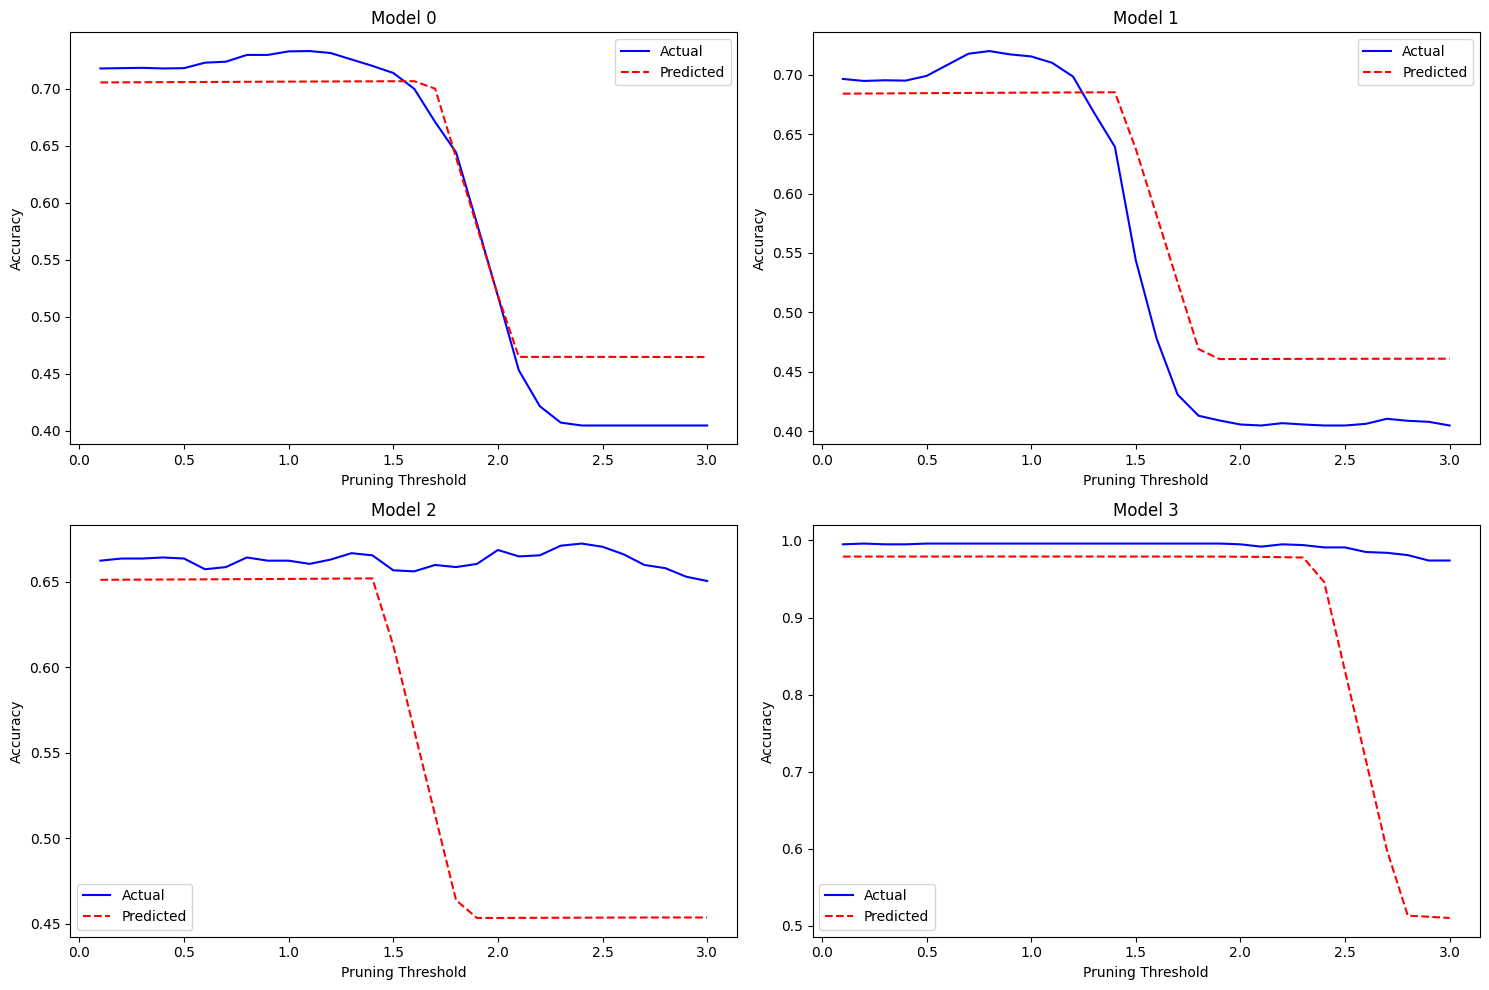

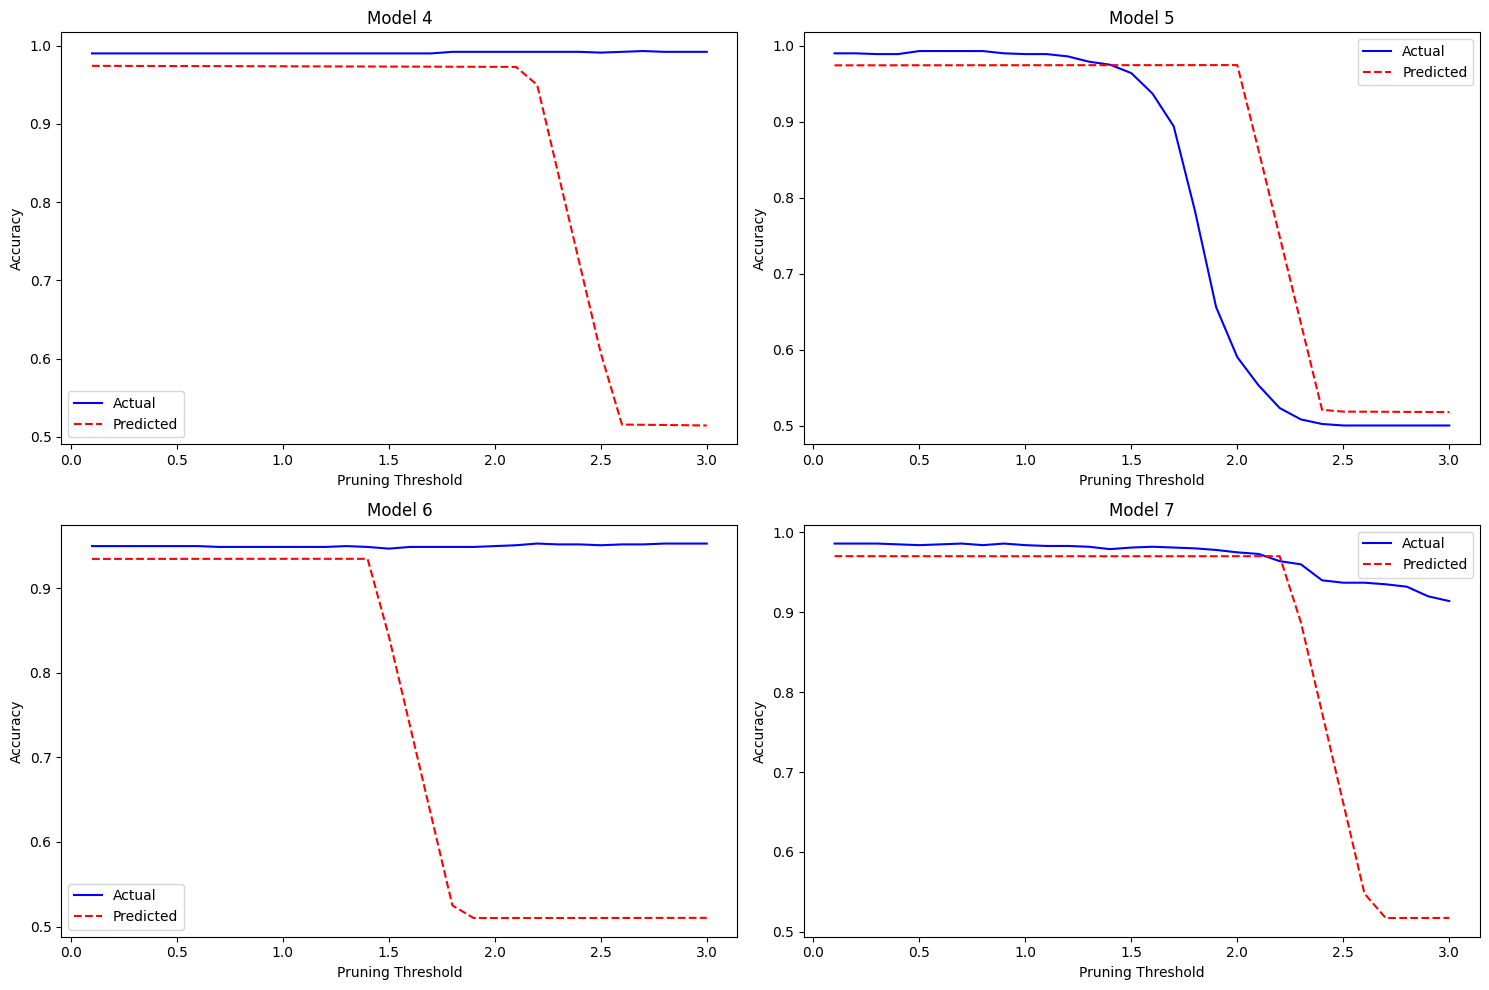

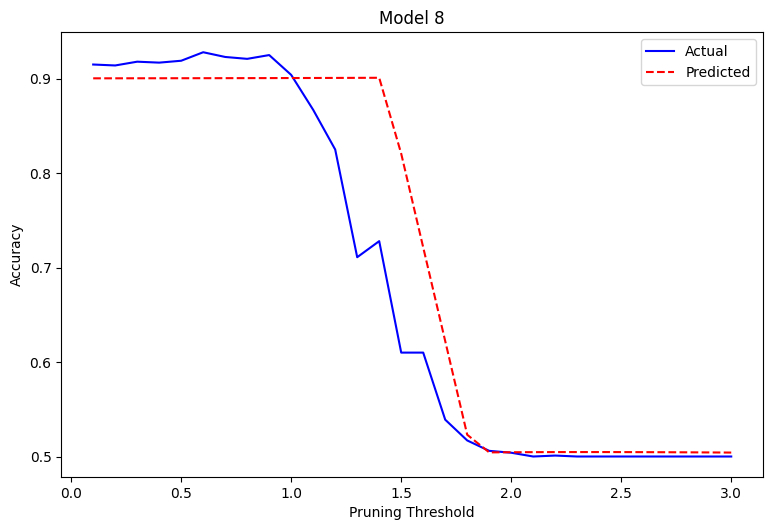

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(len(all_model_ids_test)):
    plt.subplot(2, 2, i % 4 + 1)
    plt.plot(all_thresholds, all_actual_curves[i], 'b-', label='Actual')
    plt.plot(all_thresholds, all_predicted_curves[i], 'r--', label='Predicted')
    plt.title(f'Model {all_model_ids_test[i]}')
    plt.xlabel('Pruning Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    
    if (i + 1) % 4 == 0 or i == len(all_model_ids_test) - 1:
        plt.tight_layout()
        plt.show()
        if i < len(all_model_ids_test) - 1:
            plt.figure(figsize=(15, 10))